# Use VICET to Bound Odometry Errors in LOAM initialized from a moving platform

In [5]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
# from pioneer.das.api.platform import Platform #conflict with <open3d-python>
from scipy.spatial.transform import Rotation as R
# from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp #conflict with <open3d-python>
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

2023-07-20 11:26:14.338466: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 11:26:14.439692: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-20 11:26:14.801648: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-07-20 11:26:14.801704: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-20 11:26:15.383381: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-20 11:26:15.383557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-20 11:26:15.383690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-20 11:26:15.699301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-20 11:26:15.699484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Autosaving every 180 seconds


## Load HD Map from .ply File

In [6]:
import trimesh
pl = '/media/derm/06EF-127D3/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
show_nth = 10 #10
submap = HD_map[::show_nth]

print(np.shape(submap))
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
disp.append(Points(submap, c = "black", r = 2, alpha = 0.1)) #CB2314  
plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)

(402461, 3)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## Load "Ground Truth" Poses provided in dataset

In [7]:
# [sec,nsec,x,y,z,qx,qy,qz,qw]
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"

gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #Kitware API specify offset as -134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32)
# T_CL[:3, :3] = R.from_euler('xyz', [0,0, np.deg2rad(135)]).as_matrix() #as specified by paper (exactly 45 deg)
poses = np.einsum("nij,jk->nik", poses, T_CL)
initial_pose = np.linalg.inv(poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses)
poses_eul = R.from_matrix(poses[:,:3,:3]).as_euler('xyz')
# print(poses_eul)

In [8]:
from matplotlib import pyplot as plt
start_idx = 2400
end_idx = 3341
# fig, ax = plt.subplots()
# #plot GT
# ax.plot(poses[start_idx:end_idx,:3,3], label={'x (world)',"y (world)","z (world)"})
# # ax.plot(np.diff(poses[start_idx:end_idx,:3,3], axis = 0), label={'x',"y","z"})
# # ax.plot(poses_eul)
# # ax.plot(np.diff(poses_eul, axis=0))
# ax.legend(loc="best")

# Plot GT and LOAM in 3D agaist HD Map (Dynamic Spinning)

<IPython.core.display.Javascript object>


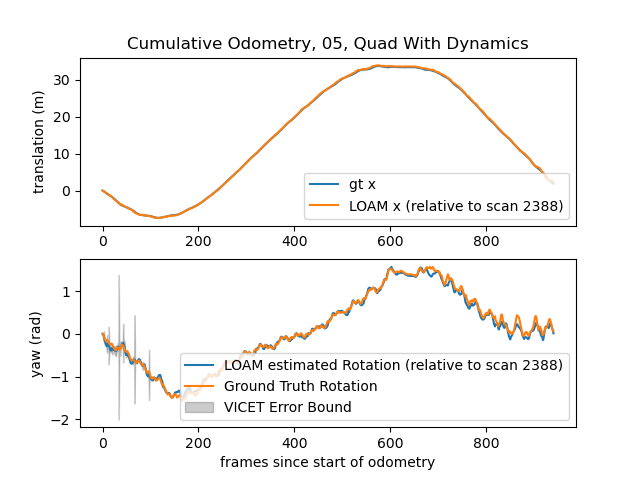

In [9]:
#Dynamic Spinning -- moving start 
# rosbag play -r 0.05 --clock -s 95 rooster_2020-07-10-09-23-18_0.bag
# fn = "results/LOAM/06_LOAM_dynamic_start.npy"
# fn = "results/LOAM/06_LOAM_dynamic_start_v2.npy" #trying again from 950
# fn = "results/LOAM/06_LOAM_dynamic_start_v3.npy" #start at 990 this time
# fn = "results/LOAM/06_LOAM_dynamic_start_v4.npy" #start at 1050
# fn = "results/LOAM/06_LOAM_dynamic_start_v5.npy" #start at 550 -->> makes really odd pattern, still doesn't work

#From static(ish) start
# rosbag play -r 0.05 --clock -s 28 rooster_2020-07-10-09-23-18_0.bag
# fn = "results/LOAM/06_LOAM_dynamic_start_v6.npy" #start at 280 (static start)
# fn = "results/LOAM/06_LOAM_dynamic_start_v7.npy" #start at 290 (starts moving early on)

fn = "results/LOAM/05_test6.npy" #start at 2400

#static start- gets right into heavy distortion

LOAM_traj = np.load(fn)

#05
start_idx = 2388 #2400
offset = 10
# #06
# start_idx = 298 #310 #950
# offset = 1 #there was a delay between when frames PC's started publishing (in rosbag) and number of gt poses

gt_wrt_initial_frame = np.linalg.pinv(poses[start_idx,:,:]) @ poses[start_idx:start_idx+len(LOAM_traj),:,:]
gt_euls = R.from_matrix(gt_wrt_initial_frame[:,:3,:3]).as_euler('xyz')

from matplotlib import pyplot as plt
fig, ax = plt.subplots(2,1)

ax[0].plot(gt_wrt_initial_frame[:,1,3], label = "gt x")
# ax[0].plot(gt_wrt_initial_frame[:,2,3], label = "gt y")

ax[0].plot(LOAM_traj[:,0], label = "LOAM x (relative to scan %i)" %start_idx)
# ax[0].plot(LOAM_traj[:,1], label = "LOAM y (relative to scan %i)" %start_idx)
# ax.plot(LOAM_traj[:,2], label = "z (relative to scan %i)" %start_idx)
# ax[0].plot(np.sqrt(LOAM_traj[:,0]**2 + LOAM_traj[:,1]**2))
ax[0].set_ylabel("translation (m)")
ax[0].legend(loc="best")

# #pitch??
# ax.plot(LOAM_traj[:,3], label = "LOAM estimated Rotation (relative to scan %i)" %start_idx)
# ax.plot(gt_euls[:,1], label = "Ground Truth Rotation")
# #roll??
# ax.plot(LOAM_traj[:,5], label = "LOAM estimated Rotation (relative to scan %i)" %start_idx)
# ax.plot(gt_euls[:,0], label = "Ground Truth Rotation")
#yaw
ax[1].plot(LOAM_traj[:,4], label = "LOAM estimated Rotation (relative to scan %i)" %start_idx)
# ax.plot(gt_euls[:,2], label = "Ground Truth Rotation")
scaled = np.arcsin(np.sin(gt_euls[:,2]))
ax[1].plot(scaled, label = "Ground Truth Rotation")

VICET_A_hist = np.load("results/VICET/VICET_06_odometry_start_at_frame_950.npy") #frame to frame
# VICET_A_hist = np.load("results/VICET/VICET_06_scan_to_keyframe_start_at_frame_950.npy") #frame to keyframe

# #make cumulative
# for i in range(1,len(VICET_A_hist)):
#     VICET_A_hist[i,:] = abs(VICET_A_hist[i,:]) + abs(VICET_A_hist[i-1,:])

ax[1].fill_between(np.linspace(0,99,100),  
                LOAM_traj[:len(VICET_A_hist),4] + abs(VICET_A_hist[:,10]),
                LOAM_traj[:len(VICET_A_hist),4] - abs(VICET_A_hist[:,10]),
                color = 'k',alpha = 0.2, label = "VICET Error Bound")
 
ax[0].set_title("Cumulative Odometry, 05, Quad With Dynamics")
# ax.set_title("Cumulative Odometry, 06 Dynamic Spinning")
ax[1].set_xlabel("frames since start of odometry")
ax[1].set_ylabel("yaw (rad)")
ax[1].legend(loc="best")

In [11]:
len(LOAM_traj[:len(VICET_A_hist),4])

100

## Ok, so I'm going to need to visualize how GT and LOAM 6D transforms are progressing

### Game plan:
Plot axis for first 100(?) frames of LOAM and gt in 3d space, find rigid transform to initialize LOAM as best as I can off of gt

Angles don't look too bad, LOAM translations have extreme drift 

In [12]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]

start_idx = 550
viewlen = 25 #how many frames to consider
arrow_scale = 0.1

#draw ground truth trajectory in 3D space
gt_axis = np.tile(np.eye(4)[None,:,:], [viewlen,1,1]) #init axis for gt
# gt_axis = poses[start_idx:(start_idx+viewlen),:,:] @ gt_axis #apply "poses" homogeneous transform to gt_axis
gt_axis = np.linalg.pinv(poses[start_idx,:,:]) @ poses[start_idx:(start_idx+viewlen),:,:] @ gt_axis #apply "poses" homogeneous transform to gt_axis
gt_axis[:,:3,3] -= gt_axis[0,:3,3] #center start at origin
for count, a in enumerate(gt_axis):
    alph = (count+1)/(viewlen+1)
    disp.append(Arrow(a[:3,3], a[:3,3] + arrow_scale*a[0,:3], c='k', alpha = alph)) #x axis 
    disp.append(Arrow(a[:3,3], a[:3,3] + arrow_scale*a[1,:3], c='k', alpha = alph)) #y axis
    disp.append(Arrow(a[:3,3], a[:3,3] + arrow_scale*a[2,:3], c='k', alpha = alph)) #x axis 
    #draw line between subsequent frames
    if count > 0:
        disp.append(Line(gt_axis[count, :3, 3], gt_axis[count-1, :3, 3], c='k', lw = 3 ))
    
#draw LOAM trajectory in 3D space
loam_axis = np.tile(np.eye(4)[None,:,:], [viewlen,1,1])
#construct homogenous transforms for LOAM
loam_homo = R.from_euler('xyz', LOAM_traj[:,3:]).as_matrix() #get rotation angles

# #add on transform, center at origin
loam_homo = np.append(loam_homo, LOAM_traj[:,:3,None] - LOAM_traj[0,:3,None], axis = 2) 
#for debug: copy paste xyz from gt to LOAM traj here to verify angles
# loam_homo = np.append(loam_homo, (poses[start_idx:start_idx+len(LOAM_traj),:3,3] - poses[start_idx,:3,3])[:,:,None],axis = 2) #add on transform, center at origin

# print((poses[start_idx:start_idx+len(LOAM_traj),:3,3] - poses[start_idx,:3,3])[:,:,None])

loam_homo = np.append(loam_homo, np.tile(np.array([0.,0.,0.,1.]), [len(loam_homo),1,1]), axis = 1) #add on last row to make homo matrix
# print(loam_homo)
loam_homo = loam_homo[:viewlen]
loam_axis = np.tile(np.eye(4)[None,:,:], [viewlen,1,1])
loam_axis = loam_homo @ loam_axis #apply "poses" homogeneous transform to gt_axis

for count, a in enumerate(loam_axis):
    alph = (count+1)/(viewlen+1)
    disp.append(Arrow(a[:3,3], a[:3,3] + arrow_scale*a[0,:3], c='blue', alpha = alph)) #x axis 
    disp.append(Arrow(a[:3,3], a[:3,3] + arrow_scale*a[1,:3], c='blue', alpha = alph)) #y axis
    disp.append(Arrow(a[:3,3], a[:3,3] + arrow_scale*a[2,:3], c='blue', alpha = alph)) #x axis 
    #draw line between subsequent frames
    if count > 0:
        disp.append(Line(loam_axis[count, :3, 3], loam_axis[count-1, :3, 3], c='blue', lw = 3 ))

plt.show(disp)
# lb = LegendBox([LOAM, gt], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
# plt.show(disp, lb, "")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [13]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
# plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]

start_idx = 950
offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + offset) + ".npy"

pc1 = np.load(fn1)
disp.append(Points(pc1, c ='red', r=3, alpha = 0.2))

#draw HD Map -------------------------------------------
submap_in_pc1_frame = (np.linalg.pinv(poses[start_idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_in_pc1_frame = submap_in_pc1_frame[:,:3]
disp.append(Points(submap_in_pc1_frame, c = "grey", r = 2, alpha = 0.1)) ##CB2314


# lb = LegendBox([], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left').font("Theemim")
# plt.show(disp, lb, "")
plt.show(disp)
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## Load LOAM results (starting at arbitrary scan idx) and plot against ground truth

#### 05_00 (1670 frames) -> 05_01 (1671 frames) -> 05_02 (646 frames)

#### NOTE: axis will not be aligned!!!

<IPython.core.display.Javascript object>


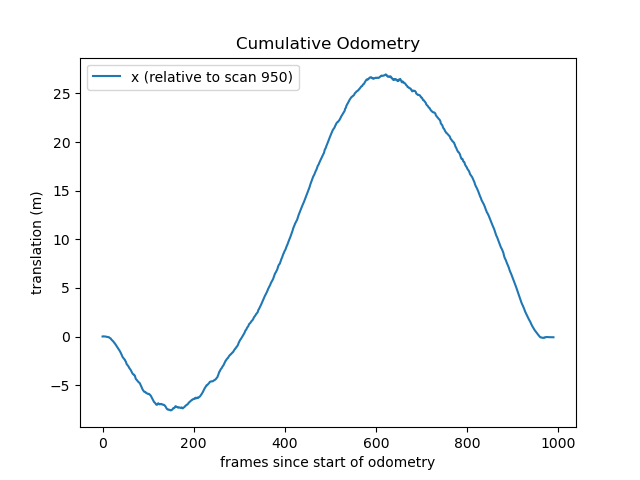

In [14]:
# fn = "results/LOAM/05_test1.npy" #before I got mapmaker working
# fn = "results/LOAM/05_test2.npy" #before I got mapmaker working

# 05_01 after reinstalling EVERYTHING and compiling pcl-1.10 from source
# fn = "results/LOAM/05_test3.npy" # 1650 long 
#makes odom estimates for overall frames 1690-3340 

# # rosbag play --clock -s 54 -r 0.05 rooster_2020-07-10-09-16-39_1.bag 
# fn = "results/LOAM/05_test4.npy" 

# # rosbag play --clock -s 55 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
# fn = "results/LOAM/05_test5.npy" #1100 frames long, starts at 2241 

# # start at 2400- very obvious forward motion distortion ()
# # rosbag play --clock -s 70.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
# fn = "results/LOAM/05_test6.npy" #playback at 0.05x speed
# # fn = "results/LOAM/05_test7.npy" #playback at 0.2x speed (slightly worse)
# # fn_fast = "results/LOAM/05_test8.npy" #playback at 1.0x speed (bad)

# one lap of running around the quad starting from static position
# fn = "results/LOAM/05_LOAM_start_from_static.npy"
fn = "results/LOAM/05_LOAM_start_from_static_v2.npy"

#Dynamic Spinning -- moving start 
# rosbag play -r 0.05 --clock -s 95 rooster_2020-07-10-09-23-18_0.bag
# fn = "results/LOAM/06_LOAM_dynamic_start.npy"

LOAM_traj = np.load(fn)
# print(LOAM_traj)
LOAM_traj =  LOAM_traj[10:,:]

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(LOAM_traj[:,0], label = "x (relative to scan %i)" %start_idx)
# ax.plot(LOAM_traj[:,1], label = "y (relative to scan %i)" %start_idx)
# ax.plot(LOAM_traj[:,2], label = "z (relative to scan %i)" %start_idx)
# ax.plot(LOAM_traj[:,5], label = "yaw (relative to scan %i)" %start_idx)
ax.set_title("Cumulative Odometry")
ax.set_xlabel("frames since start of odometry")
ax.set_ylabel("translation (m)")
ax.legend(loc="best")

# Plot GT and LOAM in 3D against HD Map (Quad With Dynamics)

In [15]:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [16]:
#amin test

A = np.array([[0,1,2],
             [3,4,5],
             [8,4,3]])
print(np.amin(A, axis = 1))

[0 3 3]


<IPython.core.display.Javascript object>


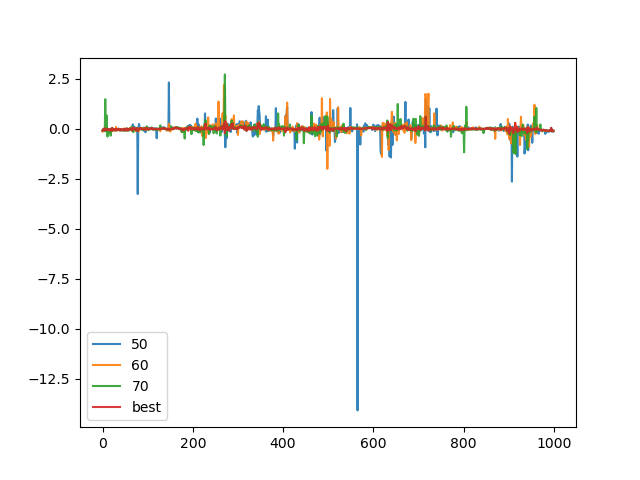

In [17]:
# Compare results of VICET at different fidelities, compile to single trajectory by using best from each
# (This is the same as doing a parameter sweep on voxel size if we were to run this in real time)
VICET_A_hist_50 = np.load("results/VICET/VICET_05_start_from_static_A_hist_v5.npy") #fid = 50
VICET_A_hist_60 = np.load("results/VICET/VICET_05_start_from_static_A_hist_v4.npy") #fid = 60
VICET_A_hist_70 = np.load("results/VICET/VICET_05_start_from_static_A_hist_v6.npy") #fid = 70
#find which trajectory has the lowest error for each frame 1-1000
A_hist_all = np.array([VICET_A_hist_50, VICET_A_hist_60, VICET_A_hist_70])
# print(np.shape(A_hist_all))
min_abs_args = np.argmin(np.abs(A_hist_all), axis = 0)
# print(np.shape(min_abs_args))
A_hist_best = np.take_along_axis(A_hist_all, min_abs_args[None, :, :], axis = 0)[0,:,:]
# print(np.shape(A_hist_best))

from matplotlib import pyplot as plt
fig, ax = plt.subplots()

axis = 0
ax.plot(VICET_A_hist_50[:,axis], alpha = 0.9, label = '50')
ax.plot(VICET_A_hist_60[:,axis], alpha = 0.9, label = '60')
ax.plot(VICET_A_hist_70[:,axis], alpha = 0.9, label = '70')
ax.plot(A_hist_best[:,axis], alpha = 0.9, label = 'best')

ax.legend(loc='best')

In [25]:
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True)
disp=[]
ptsize = 4

#init raw LOAM trajectory and OG LOAM axis
LOAM_axis = np.eye(3)
# start_idx = 2390 #for test 6, 7, 8
start_idx = 2010 #for new test (6/28)
end_idx = start_idx + len(LOAM_traj) #3341
# disp.append(Points(LOAM_traj[:,:3], alpha = 0.2)) #draw raw  LOAM data
start_point = Points([[0.,0,0]], c='red', r =15).legend("Start Position")
disp.append(start_point)

#rotate 135 deg about y axis to align initial motion with +x 
# rot_mat = R.from_euler('xyz', [0, np.deg2rad(135), 0]).as_matrix() #was this for 678
# rot_mat = R.from_euler('xyz', [0, np.deg2rad(28), 0]).as_matrix() #test
rot_mat = R.from_euler('xyz', [np.deg2rad(-3), np.deg2rad(28), np.deg2rad(-2)]).as_matrix() #test
LOAM_corr = LOAM_traj[:,:3] @ rot_mat
# LOAM_axis = LOAM_axis @ rot_mat
LOAM_axis = LOAM_axis @ R.from_euler('xyz', [0, np.deg2rad(0), np.deg2rad(-2)]).as_matrix() #test
#flip 180 deg
LOAM_corr = np.array([LOAM_corr[:,0], -LOAM_corr[:,2], LOAM_corr[:,1]]).T
LOAM_axis = np.array([LOAM_axis[0,:], -LOAM_axis[2,:], LOAM_axis[1,:]])

#draw GT trajectory
#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
# gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
#rotate 180 deg about vertical axis to align with LOAM results
# gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(180)]).as_matrix() #was this
# gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(225)]).as_matrix() #for test 678
gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(-30)]).as_matrix() #test
# gt_points = Points(gt_lidarframe[2000:3000,:3], c = "black", r=3).legend("Actual Motion of Platform")
gt_points = Line(gt_lidarframe[2000:3000,:3], c = "black", lw = 4, alpha = 0.5).legend("Actual Motion of Platform")
disp.append(gt_points)

#show LOAM corrected
# disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 3*LOAM_axis[:,0], c = 'red', alpha = 1.))
# disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 3*LOAM_axis[:,1], c = 'green', alpha = 1.))
# disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 3*LOAM_axis[:,2], c = 'blue', alpha = 1.))
# LOAM_pts = Points(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, r = ptsize).legend("LOAM")
LOAM_pts = Line(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, lw = 4).legend("LOAM")
disp.append(LOAM_pts)

#draw HD Map -------------------------------------------
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
# submap_mapframe = (poses[start_idx] @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(195)]).as_matrix()
submap_lidarframe = submap_lidarframe @ rot_mat
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.2)) ##CB2314

#draw VICET trajectory~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
start_idx_VICET = 2020 #for v1-9
# # Raw VICET file
# VICET_A_hist = np.load("results/VICET/VICET_05_start_from_static_A_hist.npy") #too noisy (Vel->rigid)
# VICET_A_hist = np.load("results/VICET/VICET_05_start_from_static_A_hist_v2.npy") #fixed (rigid->vel) (still pretty noisy...)
# VICET_A_hist = np.load("results/VICET/VICET_05_start_from_static_A_hist_v3.npy") #messing with offests in starting pose hint...
# #flipped order of points in cloud:
# VICET_A_hist = np.load("results/VICET/VICET_05_start_from_static_A_hist_v4.npy") #fid = 60
# VICET_A_hist = np.load("results/VICET/VICET_05_start_from_static_A_hist_v5.npy") #fid = 50
# VICET_A_hist = np.load("results/VICET/VICET_05_start_from_static_A_hist_v6.npy") #fid = 70
# VICET_A_hist = np.load("results/VICET/VICET_05_start_from_static_A_hist_v8.npy") #fid = 40, test 7/11 
# VICET_A_hist = np.load("results/VICET/VICET_05_start_from_static_A_hist_v9.npy") #fid = 70, apply correctiion within loop

# start_idx_VICET = 2700 
# start_idx_VICET = 1700 #test
# VICET_A_hist = np.load("results/VICET/VICET_05_start_from_2700_v5.npy")
# VICET_A_hist = np.load("results/VICET/VICET_05_start_from_1700_v1.npy")

# VICET_A_hist_v1 = np.load("results/VICET/VICET_05_start_from_2700.npy")
# VICET_A_hist_v2 = np.load("results/VICET/VICET_05_start_from_2700_v2.npy")
# VICET_A_hist_v3 = np.load("results/VICET/VICET_05_start_from_2700_v3.npy")
# VICET_A_hist_v4 = np.load("results/VICET/VICET_05_start_from_2700_v4.npy")
# VICET_A_hist_v5 = np.load("results/VICET/VICET_05_start_from_2700_v5.npy")
# A_hist_all = np.array([VICET_A_hist_v1, VICET_A_hist_v2, VICET_A_hist_v3, VICET_A_hist_v4, VICET_A_hist_v5])
# min_abs_args = np.argmin(np.abs(A_hist_all), axis = 0)
# VICET_A_hist = np.take_along_axis(A_hist_all, min_abs_args[None, :, :], axis = 0)[0,:,:]


# VICET "Parameter Sweep" ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Compare results of VICET at different fidelities, compile to single trajectory by using best from each
# (This is the same as doing a parameter sweep on voxel size if we were to run this in real time)
VICET_A_hist_50 = np.load("results/VICET/VICET_05_start_from_static_A_hist_v5.npy") #fid = 50
VICET_A_hist_60 = np.load("results/VICET/VICET_05_start_from_static_A_hist_v4.npy") #fid = 60
VICET_A_hist_70 = np.load("results/VICET/VICET_05_start_from_static_A_hist_v6.npy") #fid = 70
VICET_A_hist_40 = np.load("results/VICET/VICET_05_start_from_static_A_hist_v8.npy") #fid = 40 
#find which trajectory has the lowest error for each frame 1-1000
A_hist_all = np.array([VICET_A_hist_50, VICET_A_hist_60, VICET_A_hist_70, VICET_A_hist_40])
min_abs_args = np.argmin(np.abs(A_hist_all), axis = 0)
VICET_A_hist = np.take_along_axis(A_hist_all, min_abs_args[None, :, :], axis = 0)[0,:,:]
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3] + 
#               VICET_A_hist[:,:3] + VICET_A_hist[:,6:9])
VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3] + VICET_A_hist[:,:3])
# VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3])

#line up at start
VICET_traj -= VICET_traj[0,:]
#rotate to align with gt
VICET_traj = VICET_traj @ R.from_euler('xyz', [0,0,np.deg2rad(196)]).as_matrix()

# VICET_points = Points(VICET_traj[:,:3], c='green', r=ptsize, alpha = 0.8).legend("VICET")
VICET_points = Line(VICET_traj[:,:3], lw = 3, c='green', alpha = 1).legend("VICET")
disp.append(VICET_points)

#draw ICET trajectory~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ICET_A_hist = np.load("results/ICET/ICET_05_start_from_static_A_hist.npy")
# ICET_A_hist = np.load("results/ICET/ICET_05_start_from_static_A_hist_v2.npy") #run again 7/11, fid = 40

# ICET_A_hist = np.load("results/ICET/ICET_05_start_from_2700_v5.npy") #200 frames only
# ICET_A_hist = np.load("results/ICET/ICET_05_start_from_1700_v1.npy") #100 frames only

# ICET_A_hist_v1 = np.load("results/ICET/ICET_05_start_from_2700.npy")
# ICET_A_hist_v2 = np.load("results/ICET/ICET_05_start_from_2700_v2.npy")
# ICET_A_hist_v3 = np.load("results/ICET/ICET_05_start_from_2700_v3.npy")
# ICET_A_hist_v4 = np.load("results/ICET/ICET_05_start_from_2700_v4.npy")
# ICET_A_hist_v5 = np.load("results/ICET/ICET_05_start_from_2700_v5.npy")
# A_hist_all = np.array([ICET_A_hist_v1, ICET_A_hist_v2, ICET_A_hist_v3, ICET_A_hist_v4,  ICET_A_hist_v5])
# min_abs_args = np.argmin(np.abs(A_hist_all), axis = 0)
# ICET_A_hist = np.take_along_axis(A_hist_all, min_abs_args[None, :, :], axis = 0)[0,:,:]

# ICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3] + ICET_A_hist[:,:3])

# #line up at start
# ICET_traj -= ICET_traj[0,:]
# #rotate to align with gt
# ICET_traj = ICET_traj @ R.from_euler('xyz', [0,0,np.deg2rad(196)]).as_matrix()

# # ICET_points = Points(ICET_traj[:,:3], c=[65,64,255], r=5, alpha = 0.5).legend("Rigid ICET")
# # ICET_points = Points(ICET_traj[:,:3], c='blue', r=ptsize, alpha = 0.5).legend("ICET")
# ICET_points = Line(ICET_traj[:,:3], c='blue', lw=3, alpha = 0.5).legend("ICET")
# disp.append(ICET_points)

# Draw ICP trajectory ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# need to flip sign for ICP since transforms are backwards here

# ICP_A_hist = -np.load("results/ICP/ICP_05_start_from_2700_v4.npy")
# ICP_A_hist = -np.load("results/ICP/ICP_05_start_from_1700_v1.npy")

# ICP_A_hist_v1 = -np.load("results/ICP/ICP_05_start_from_2700_v1.npy")
# ICP_A_hist_v2 = -np.load("results/ICP/ICP_05_start_from_2700_v2.npy")
# ICP_A_hist_v3 = -np.load("results/ICP/ICP_05_start_from_2700_v3.npy")
# ICP_A_hist_v4 = -np.load("results/ICP/ICP_05_start_from_2700_v4.npy")
# A_hist_all = np.array([ICP_A_hist_v1, ICP_A_hist_v2, ICP_A_hist_v3, ICP_A_hist_v4])
# min_abs_args = np.argmin(np.abs(A_hist_all), axis = 0)
# ICP_A_hist = np.take_along_axis(A_hist_all, min_abs_args[None, :, :], axis = 0)[0,:,:]
# #test-- flip y and z
# ICP_A_hist = np.array([ICP_A_hist[:,0], ICP_A_hist[:,2],  ICP_A_hist[:,1], ICP_A_hist[:,3], ICP_A_hist[:,4], ICP_A_hist[:,5]]).T
# ICP_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3] + ICP_A_hist[:,:3])

# #line up at start
# ICP_traj -= ICP_traj[0,:]
# #rotate to align with gt
# ICP_traj = ICP_traj @ R.from_euler('xyz', [0,0,np.deg2rad(196)]).as_matrix()

# ICP_points = Line(ICP_traj[:,:3], c='orange', lw=3, alpha = 0.5).legend("ICP")
# disp.append(ICP_points)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# lb = LegendBox([gt_points, start_point, LOAM_pts, VICET_points], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
lb = LegendBox([gt_points, start_point, LOAM_pts, VICET_points , ICET_points, ICP_points], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
plt.show(disp, lb, "")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [19]:
# print(ICP_A_hist)
# test = np.array([ICP_A_hist[:,0], ICP_A_hist[:,2],  ICP_A_hist[:,1], ICP_A_hist[:,3], ICP_A_hist[:,4], ICP_A_hist[:,5]]).T
# print(test)

# pred_stds = np.load("results/VICET/VICET_pred_stds_05_start_from_1700_v1.npy")

print(pred_stds)

NameError: name 'pred_stds' is not defined

<IPython.core.display.Javascript object>


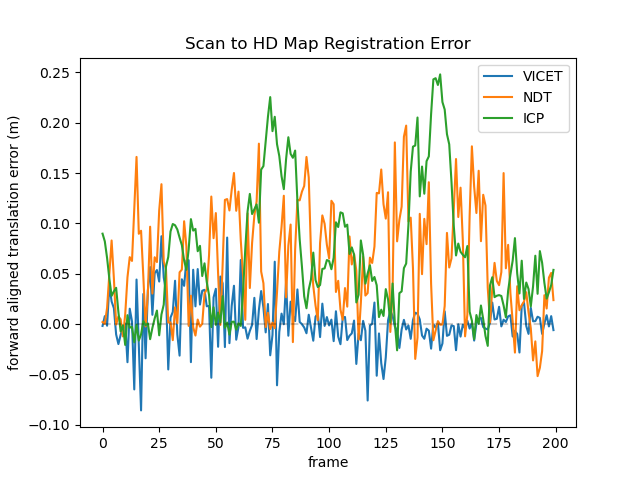

In [20]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(VICET_A_hist[:,0], label = "VICET")
ax.plot(ICET_A_hist[:,0], label = "NDT")
ax.plot(ICP_A_hist[:,0], label = "ICP")

ax.plot(np.zeros(len(ICET_A_hist)), 'k--', alpha = 0.2) #dotted line at zero error
ax.set_title("Scan to HD Map Registration Error")
ax.set_xlabel("frame")
ax.set_ylabel("forward aligned translation error (m)")
# ax.plot(np.diff(poses[:,:3,3], axis = 0))

# ax.fill_between(x = np.linspace(0,len(VICET_A_hist)-1,len(VICET_A_hist)), 
#                 y1 = abs(VICET_A_hist[:,6]), 
#                 y2 = -abs(VICET_A_hist[:,6]),
#                 color = 'blue', alpha = 0.2, label = "VICET forward motion compensation")

ax.legend(loc="best")

# print(VICET_A_hist[:10,0])
# print(VICET_A_hist[:10,6])

In [398]:
#get RMSE for ICP, NDT, and VICET
VICET_error = VICET_A_hist[:,:6] #get rid of correction states for now

#forward translation only
ICET_RMSE = np.sqrt(np.mean(ICET_A_hist[:,0]**2))
VICET_RMSE = np.sqrt(np.mean(VICET_error[:,0]**2))
ICP_RMSE = np.sqrt(np.mean(ICP_A_hist[:,0]**2))

print(ICET_RMSE)
print(VICET_RMSE)
print(ICP_RMSE)

0.08097888200823608
0.026258009823134164
0.09269449589079425


# plot VICET against GT

<IPython.core.display.Javascript object>


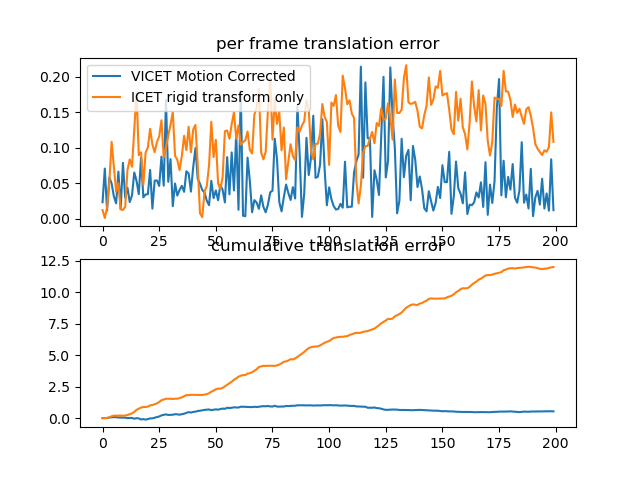

Text(0.5, 1.0, 'cumulative translation error')

In [393]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2,1)

# #remover huge outliers in both ICET and VICET
# # VICET_error = VICET_A_hist[:,:6] - VICET_A_hist[:,6:] #full correction
# VICET_error = VICET_A_hist[:,:6] - VICET_A_hist[:,6:]/2 #half correction
VICET_error = VICET_A_hist[:,:6] #no correction
# VICET_error[abs(VICET_error[:,0]) > 0.25 ] = 0
ICET_error = ICET_A_hist[:,0]
# ICET_error[abs(ICET_error) > 0.25] = 0

VICET_cum_error = np.zeros([len(VICET_A_hist),6])
ICET_cum_error = np.zeros([len(VICET_A_hist),6])
for i in range(1,len(VICET_cum_error)):
    #just use VICET rigid estimate
#     VICET_cum_error[i,:] = VICET_cum_error[i-1,:] + VICET_A_hist[i,:6] 
    #apply correction factor
    VICET_cum_error[i,:] = VICET_cum_error[i-1,:] + VICET_error[i,:]
    ICET_cum_error[i,:] = ICET_cum_error[i-1,:] + ICET_A_hist[i,:6]


# ax[1].plot(VICET_A_hist[:,0])
# ax[1].plot(ICET_A_hist[:,0])
# ax[1].plot(gt_lidarframe[2020:2020+len(VICET_A_hist),:3])
# ax[1].plot(gt_lidarframe[2020:2020+len(VICET_A_hist),:3] + VICET_A_hist[:,:3])

#compare rigid ICET vs VICET
# ax[0].plot(VICET_error[:,0], label='VICET Motion Corrected')
ICET_error = np.sqrt(ICET_A_hist[:,0]**2 + ICET_A_hist[:,1]**2)

VICET_error = np.sqrt(VICET_error[:,0]**2 + VICET_error[:,1]**2)
VICET_error[abs(VICET_error) > 0.25 ] = ICET_error[abs(VICET_error) > 0.25 ] 


ax[0].plot(VICET_error[:], label='VICET Motion Corrected')
ax[0].plot(ICET_error[:], label="ICET rigid transform only")
ax[0].legend(loc='best')
ax[0].set_title("per frame translation error")

#bottom plot: look at cumulative error output of ICET -- this is initial transform + VICET rigid component
ax[1].plot(VICET_cum_error[:,0])
ax[1].plot(ICET_cum_error[:,0])
ax[1].set_title("cumulative translation error")

<IPython.core.display.Javascript object>


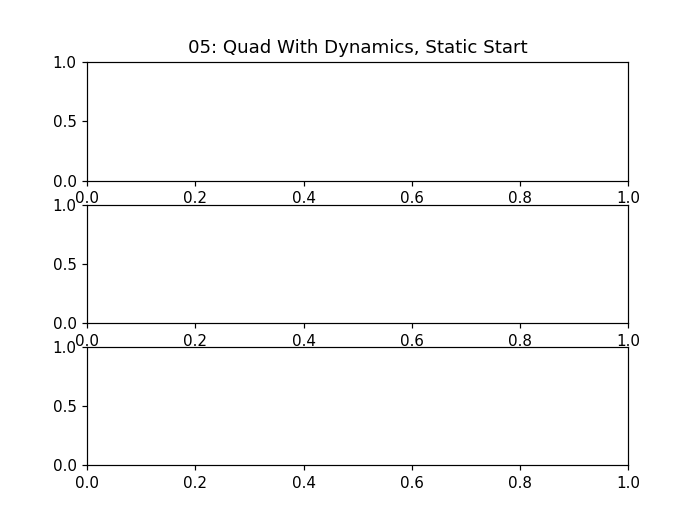

ValueError: x and y must have same first dimension, but have shapes (980,) and (180,)

In [171]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(3,1)
ax[0].set_title("05: Quad With Dynamics, Static Start")
lw = 2
alph = 0.7
# x_vec = np.linspace(2240, 2241 + len(LOAM_corr), len(LOAM_corr) )
x_vec = np.linspace(2020, 2021 + len(LOAM_corr), len(LOAM_corr) )

# ax[0].plot(x_vec, gt_lidarframe[start_idx:end_idx,0], label = "gt")
ax[0].plot(x_vec[:-10], VICET_traj[20:,0], label = 'VICET', linewidth = lw, alpha = alph)
ax[0].plot(x_vec, LOAM_corr[:,0], label = "LOAM", lw = lw,  alpha = alph)
ax[0].plot(x_vec, gt_lidarframe[start_idx+30:end_idx+30,0], 'k--', label = "gt")
# ax[0].plot(x_vec, ICET_traj[10:,0], label = 'ICET')
ax[0].set_ylabel("translation in x (m)")
ax[0].legend(loc='upper right')

ax[1].set_ylabel("translation in y (m)")
ax[1].plot(x_vec[:-10], VICET_traj[20:,1], label = 'VICET', linewidth = lw, alpha = alph)
ax[1].plot(x_vec, LOAM_corr[:,1], label = "LOAM", linewidth = lw, alpha = alph)
# ax[1].plot(x_vec, gt_lidarframe[start_idx:end_idx,1], label = "gt")
ax[1].plot(x_vec, gt_lidarframe[start_idx+30:end_idx+30,1], 'k--', label = "gt")
ax[1].legend(loc='upper right')

#~~~~~~~WRONG???: 
# LOAM_yaw = np.arcsin(np.sin(LOAM_traj[:,4]))
# gt_yaw = np.arcsin(np.sin(R.from_quat(gt[:, 5:]).as_euler('xyz')[:,2] + np.deg2rad(0)) )


LOAM_yaw = LOAM_traj[:,4]
gt_yaw = R.from_quat(gt[:, 5:]).as_euler('xyz')[:,2]

#attempt at fixing:
LOAM_yaw = np.arcsin(np.sin(np.pi - LOAM_yaw))



VICET_yaw = R.from_matrix(poses[start_idx+30:end_idx+30,:3,:3]).as_euler('xyz')+VICET_A_hist[10:,3:6]
VICET_yaw = np.arcsin(np.sin(VICET_yaw[:,2] + np.deg2rad(-76)) )
ax[2].plot(x_vec, VICET_yaw, label = "VICET", linewidth = lw, alpha = alph)


# ICET_yaw = R.from_matrix(poses[start_idx+30:end_idx+30,:3,:3]).as_euler('xyz')+ICET_A_hist[10:,3:6]
# ICET_yaw = np.arcsin(np.sin(ICET_yaw[:,2] + np.deg2rad(-76)) )
# ax[2].plot(x_vec, ICET_yaw, label = "ICET", linewidth = lw, alpha = alph)


ax[2].set_xlabel("Frame Index")
# ax[2].set_ylabel("yaw (rad)")
ax[2].set_ylabel("yaw (rad)")
ax[2].plot(x_vec, LOAM_yaw, label = "LOAM", linewidth = lw, alpha = alph)
# ax[2].plot(x_vec, gt_yaw[start_idx-3:end_idx-3])
ax[2].plot(x_vec, gt_yaw[start_idx+30:end_idx+30], 'k--', label = 'gt')
ax[2].legend(loc='upper right')

In [ ]:
np.rad2deg(np.arcsin(np.sin(np.deg2rad(120))))

In [ ]:
fig, ax = plt.subplots(3,1)
viewlen = 100 #view only this many frames since initialization
alph = 0.3
A_hist = np.load("results/LOAM/A_hist_05_test6.npy")

#TODO: transform A_hist from sensor body frame (for each scan) to init body frame
#      this will explain why x is too small, y is too big

ax[0].set_title("LOAM Error: Quad With Dynamics Moving Start")
# ax[0].plot(LOAM_corr[:viewlen,0] - gt_lidarframe[start_idx:(start_idx + viewlen),0], label = "LOAM Error")
ax[0].plot(LOAM_corr[:viewlen,0] - gt_lidarframe[start_idx+30:(start_idx + viewlen +30),0], label = "LOAM Error")
ax[0].fill_between(x = np.linspace(0,len(A_hist)-1,len(A_hist)), 
                   y1 = abs(A_hist[:,7])/2, 
                   y2 = -abs(A_hist[:,7])/2,
                   color = 'blue', alpha = alph, label = "VICET estimated error bound")
ax[0].legend(loc='best')

ax[0].set_ylabel("translation error in x (m)")

ax[1].set_ylabel("translation error in y (m)")
# ax[1].plot(LOAM_corr[:viewlen,1] - gt_lidarframe[start_idx:(start_idx+viewlen),1])
ax[1].plot(LOAM_corr[:viewlen,1] - gt_lidarframe[start_idx+30:(start_idx+viewlen+30),1])
ax[1].fill_between(x = np.linspace(0,len(A_hist)-1,len(A_hist)), 
                   y1 = abs(A_hist[:,8])/2, 
                   y2 = -abs(A_hist[:,8])/2,
                   color = 'blue', alpha = alph)

ax[2].set_ylabel("yaw error (degrees)")
ax[2].set_xlabel("frame idx since LOAM initialzation")
# ax[2].plot(gt_yaw[start_idx+30:(start_idx + viewlen + 30)] - LOAM_yaw[:100])
ax[2].plot(np.rad2deg(gt_yaw[start_idx+30:(start_idx + viewlen + 30)] - LOAM_yaw[:100]))
ax[2].fill_between(x = np.linspace(0,len(A_hist)-1,len(A_hist)), 
                   y1 = np.rad2deg(abs(A_hist[:,11])/2), 
                   y2 = np.rad2deg(-abs(A_hist[:,11])/2),
                   color = 'blue', alpha = alph)

# Use VICET to Estimate Error Bounds (single frame)

In [ ]:
#load scans
# idx = 2400 #2700 #2650 #2000 - 3000 is the running and swinging loop
idx = 2400 #very obvious translation distortion
skip = 40 #how many lidar frames between clouds
# (need to deal with how there are more LIDAR frames than ground truth poses)
offset = 10 #10 #11  #works best for 05 dataset
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

# idx = 950 #1080 #950 #fast motion
# # idx = 116 #slow distortion, very accurate solution
# skip = 3 #how many lidar frames between clouds
# offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + offset) + ".npy"
# fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

pc1 = np.load(fn1)
pc2 = np.load(fn2)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#apply homogeneous transform matrix
scan1_mapframe = (poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
scan2_mapframe = (poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

# #Rotate scans to align beginning of each scan with +X axis ----------
# #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
# #           this is becuase overall trajectory begins at 05 (at least I think that's why)
# #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
# scan1_mapframe = (np.linalg.pinv(poses[idx]) @ scan1_mapframe.T).T 
# scan2_mapframe = (np.linalg.pinv(poses[idx]) @ scan2_mapframe.T).T
# submap_mapframe = (np.linalg.pinv(poses[idx]) @ submap_mapframe.T).T
# #--------------------------------------------------------------------

#remove 4th column and center first scan about origin
scan1_lidarframe = scan1_mapframe[:,:3] - poses[idx][:3,3]
scan2_lidarframe = scan2_mapframe[:,:3] - poses[idx][:3,3]
submap_lidarframe = submap_mapframe[:,:3] - poses[idx][:3,3]

#COLOR SCAN1 POINTS BY ORDER IN CLOUD
# color = 255*np.linspace(0,1,len(scan1_lidarframe))
# cname = np.array([255-color//2, color, 255-color]).T.tolist()
# disp.append(Points(scan1_lidarframe, c = cname, r = 3, alpha = 1))
# disp.append(Points(pc1, c = cname, r = 3, alpha = 1))

#alt: transform pc2 to pc1 frame
disp.append(Points(pc1, c = '#a65852', r = 3)) #red
# disp.append(Points(pc2, c = '#2c7c94', r = 3)) #blue
pc2_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
disp.append(Points(pc2_in_pc1_frame, c = '#2c7c94', r = 3)) #blue

submap_pc1_frame = (np.linalg.pinv(poses[idx]) @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T[:,:3]
# disp.append(Points(submap_pc1_frame, c = "black", r = 2, alpha = 0.1)) ##CB2314

# disp.append(Points(submap_lidarframe, c = "black", r = 2, alpha = 0.1)) ##CB2314
plt.show(disp, "05 Quad With Dynamics Frame #" + str(idx))
# plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)

In [ ]:
from linear_corrector import LC
A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
max_buffer = 0.5 #was 2.5
SOLVER = '12_state' #VICET
# SOLVER = '6_state' #pins rigid transform in place (for debug only)

# dc = LC(cloud1 = scan1_lidarframe, cloud2 = scan2_lidarframe, fid = 50, niter = 50, 
#         draw = True, mnp = 25, RM = False, solver = SOLVER, 
#         max_buffer = max_buffer, A0 = A0)

dc = LC(cloud1 = pc1, cloud2 = pc2_in_pc1_frame, fid = 80, niter = 50, 
        draw = True, mnp = 25, RM = True, solver = SOLVER, 
        max_buffer = max_buffer, A0 = A0)


ViewInteractiveWidget(dc.plt.window)

In [ ]:
#debug: run VICET a bunch of times to look at spread of values for each param in A_hat
runlen = 30
A_hist = np.zeros([runlen,12])

for i in range(30):
    A0 = np.array([0., 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 0])
    max_buffer = 0.5 #0.5 #was 2.5
    SOLVER = '12_state' #VICET
    # SOLVER = '6_state' #pins rigid transform in place (for debug only)
    # scan to scan
    dc = LC(cloud1 = scan1_lidarframe, cloud2 = scan2_lidarframe, fid = 80, niter = 50, 
            draw = False, mnp = 25, RM = True, solver = SOLVER, 
            max_buffer = max_buffer, A0 = A0)    
    A_hist[i,:] = dc.A

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

ax.plot(abs(A_hist[:,6:]))

print(np.mean(abs(A_hist[:,6:]), axis = 0))

# loop through 100 frame sequence

In [ ]:
A_hist = np.zeros([110,12])
viewlen = 100

for i in range(1,viewlen + 1):
    print("\n \n Frame", i, "of 110 \n \n")
    
    #load scans
    idx = 2400 
    skip = i #how many lidar frames between clouds
    # (need to deal with how there are more LIDAR frames than ground truth poses)
    offset = 10 #10 #11  #works best for 05 dataset
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
    fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

    # idx = 950 #1080 #950 #fast motion
    # # idx = 116 #slow distortion, very accurate solution
    # skip = 3 #how many lidar frames between clouds
    # offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
    # fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + offset) + ".npy"
    # fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

    pc1 = np.load(fn1)
    pc2 = np.load(fn2)
    #apply homogeneous transform matrix
    scan1_mapframe = (poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
    scan2_mapframe = (poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
    # #Rotate scans to align beginning of each scan with +X axis ----------
    # #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
    # #           this is becuase overall trajectory begins at 05 (at least I think that's why)
    # #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
    # scan1_mapframe = (np.linalg.pinv(poses[idx]) @ scan1_mapframe.T).T 
    # scan2_mapframe = (np.linalg.pinv(poses[idx]) @ scan2_mapframe.T).T
    # submap_mapframe = (np.linalg.pinv(poses[idx]) @ submap_mapframe.T).T
    # #--------------------------------------------------------------------
    #remove 4th column and center first scan about origin
    scan1_lidarframe = scan1_mapframe[:,:3] - poses[idx][:3,3]
    scan2_lidarframe = scan2_mapframe[:,:3] - poses[idx][:3,3]
    submap_lidarframe = submap_mapframe[:,:3] - poses[idx][:3,3]
    

    pc2_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
    
    #run VICET
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    max_buffer = 0.5
    SOLVER = '12_state' #VICET
#     SOLVER = '6_state' #pins rigid transform in place (for debug only)
    m_hat0 = np.array([0.0, 0.0, 0., 0., 0., 0.])

    #I think LIDARFRAME stuff is wrong actully...
#     dc = LC(cloud1 = scan1_lidarframe, cloud2 = scan2_lidarframe, fid = 80, niter = 15, 
#         draw = False, mnp = 25, RM = True, solver = SOLVER, 
#         max_buffer = 2.5, A0 = A0, m_hat0 = m_hat0)
    dc = LC(cloud1 = pc1, cloud2 = pc2_in_pc1_frame, fid = 80, niter = 50, 
        draw = False, mnp = 25, RM = True, solver = SOLVER, 
        max_buffer = max_buffer, A0 = A0, m_hat0 = m_hat0)


    if SOLVER == '6_state':
        A_hist[i,6:] = dc.m_hat
    else:
        A_hist[i,:] = dc.A

In [ ]:
# print(np.save.__doc__)
# np.save("results/LOAM/A_hist_05_test6", A_hist)

A_hist = np.load("results/LOAM/A_hist_05_test6.npy")